In [2]:
from transformers import AutoTokenizer
from datasets import load_dataset
from transformers import TrainingArguments
from transformers import Trainer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
import torch
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

2025-05-29 07:14:27.996381: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-29 07:14:28.002311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748524468.012882  145351 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748524468.016054  145351 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748524468.024468  145351 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748524468.024482  145351 computation_placer.cc:177] computation placer already registered. Please che

In [3]:
# Info cells
print(type(model_ckpt))
model_ckpt

<class 'str'>


'distilbert-base-uncased'

In [4]:
# Info cells
print(type(tokenizer))
tokenizer

<class 'transformers.models.distilbert.tokenization_distilbert_fast.DistilBertTokenizerFast'>


DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [5]:


num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to("cpu"))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Info cells
print(type(num_labels))
num_labels

<class 'int'>


6

In [7]:
# Info cells
print(type(model))
model

<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'>


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [8]:


emotions = load_dataset("emotion")


In [9]:
# Type of var
print(type(emotions))

<class 'datasets.dataset_dict.DatasetDict'>


In [10]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [14]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [12]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

print(type(emotions_encoded))
emotions_encoded

<class 'datasets.dataset_dict.DatasetDict'>


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [11]:


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "f1": f1,
    }
    

In [12]:


batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"

training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [13]:


trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

trainer.train()

/tmp/ipykernel_16594/3836207251.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Step,Training Loss
250,0.886600
500,0.260900


TrainOutput(global_step=500, training_loss=0.5737560424804687, metrics={'train_runtime': 122.055, 'train_samples_per_second': 262.177, 'train_steps_per_second': 4.097, 'total_flos': 720342861696000.0, 'train_loss': 0.5737560424804687, 'epoch': 2.0})

In [14]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [15]:
preds_output.metrics

{'test_loss': 0.21552759408950806,
 'test_accuracy': 0.922,
 'test_f1': 0.9219468562159866,
 'test_runtime': 2.1009,
 'test_samples_per_second': 951.963,
 'test_steps_per_second': 15.231}

In [16]:


y_preds = np.argmax(preds_output.predictions, axis=1)

In [17]:



def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [18]:
from torch import nn
import torch
from transformers import AutoModel

# Supón que tienes tu modelo cargado:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt)
model.to(device)
model.eval()

def extract_hidden_states(batch):
    # mover cada tensor al mismo dispositivo que el modelo
    inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
    
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    
    # Tomamos la representación del [CLS] token
    cls_embeddings = last_hidden_state[:, 0, :]

    return {"hidden_state": cls_embeddings.cpu().numpy()}  # lo devolvemos a CPU para map


In [19]:


emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

emotions_hidden["train"].column_names

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_encoded["train"]["label"])
y_valid = np.array(emotions_encoded["validation"]["label"])
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape


((16000, 768), (2000, 768), (16000,), (2000,))

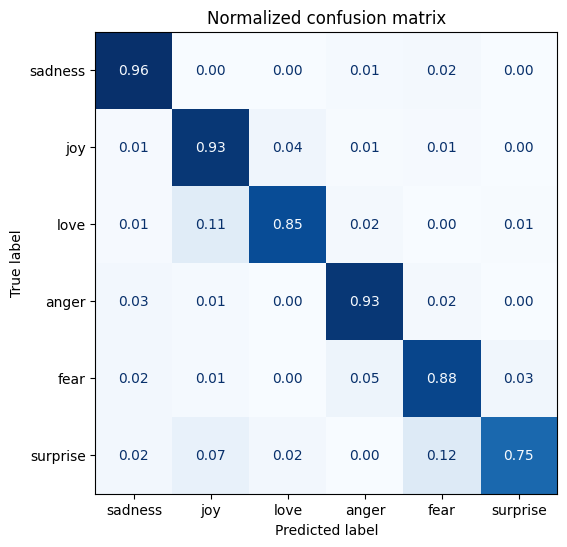

In [20]:
labels = emotions["train"].features["label"].names

plot_confusion_matrix(y_preds, y_valid, labels)

In [22]:

textos_prueba = [
    "I love the basketball court, but I don't like that it's unpainted, but I would definitely go back.",
    "I'm feeling really down today.",
    "This movie was absolutely hilarious!",
    "I have no opinion about the event.",
]

inputs = tokenizer(textos_prueba, return_tensors="pt", padding=True, truncation=True)

device = model.device
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_ids = torch.argmax(logits, dim=-1)

label_names = emotions_encoded["train"].features["label"].names

for texto, class_id in zip(textos_prueba, predicted_class_ids):
    predicted_label = label_names[class_id.item()]
    print(f"Texto: {texto}")
    print(f"Predicción: {predicted_label}")
    print()

AttributeError: 'BaseModelOutput' object has no attribute 'logits'